In [304]:
%load_ext autoreload
%autoreload 2
from capuchin import compute_accuracy, model_selection, plot_model_selection, plot_weights

import os, requests
import numpy as np

from scipy.stats import zscore
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data loading

In [2]:
datapath = '/home/droumis/data/Steinmetz-2019/npz/'

fname = []
for j in range(3):
  fname.append(f'{datapath}steinmetz_part%d.npz'%j)

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load(f'{datapath}steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [3]:
# use sessions 7 and 38 to start
dat = alldat[7]

In [4]:
dat.keys()

dict_keys(['spks', 'wheel', 'pupil', 'lfp', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'brain_area_lfp', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'waveform_w', 'waveform_u', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'lfp_passive', 'pupil_passive', 'wheel_passive'])

In [5]:
np.unique(dat['brain_area'])

array(['CA1', 'CA3', 'DG', 'ILA', 'LD', 'LP', 'LSr', 'MOs', 'PL', 'PO',
       'SUB', 'TT', 'VISa', 'VISp', 'root'], dtype='<U4')

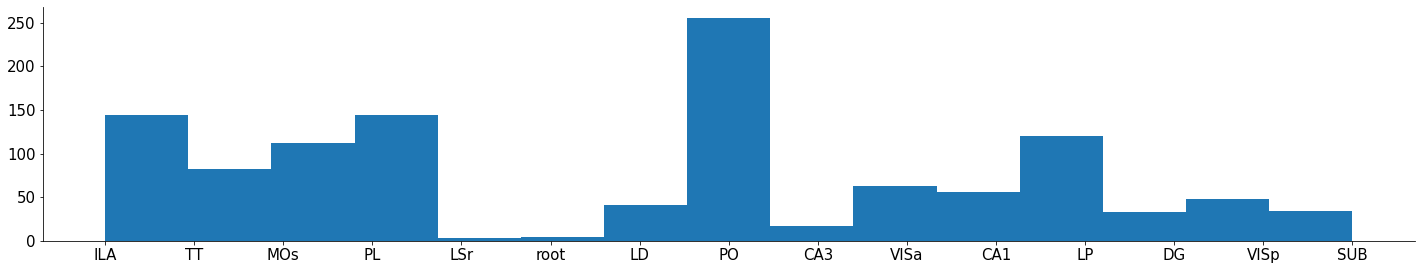

In [6]:
plt.hist(dat['brain_area'], bins=len(np.unique(dat['brain_area'])))
plt.show()

In [9]:
ILA = np.where([dat['brain_area'] == 'ILA'])[1]
PLA = np.where([dat['brain_area'] == 'PL'])[1]
CA1 = np.where([dat['brain_area'] == 'CA1'])[1]
VISp = np.where([dat['brain_area'] == 'VISp'])[1]

print(ILA.shape, PLA.shape, CA1.shape, VISp.shape)

## create y var: if trial was correct

response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
is_correct = np.sign(response)==np.sign(vis_left-vis_right)

# sort by correct, and then by response
# isort = np.argsort(-is_correct.astype('float32') + response/10) 

## set time period, area

In [48]:
np.linspace(0,90,10)

array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.])

In [51]:
startbins = np.linspace(0,80,9)
endbins = np.linspace(10,90,9)
endbins

array([10., 20., 30., 40., 50., 60., 70., 80., 90.])

(250, 250)

In [66]:

ndat = np.squeeze(dat['spks'][barea[n],:,:90]) # trials by time bins
is_correct.shape

(250,)

In [86]:
ndat = np.squeeze(dat['spks'][barea[n],:,:90])

In [87]:
ndat_mean = np.nanmean(ndat,0)
ndat_std = np.nanstd(ndat,0)

In [93]:
np.tile(ndat_std,ndat.

TypeError: 'int' object is not subscriptable

In [95]:
ndat_mean

array([0.012, 0.02 , 0.032, 0.04 , 0.032, 0.016, 0.02 , 0.044, 0.02 ,
       0.032, 0.028, 0.064, 0.04 , 0.036, 0.032, 0.032, 0.032, 0.036,
       0.048, 0.032, 0.036, 0.04 , 0.016, 0.036, 0.012, 0.028, 0.036,
       0.02 , 0.036, 0.028, 0.036, 0.02 , 0.036, 0.04 , 0.024, 0.04 ,
       0.072, 0.032, 0.032, 0.056, 0.044, 0.036, 0.04 , 0.024, 0.056,
       0.036, 0.044, 0.044, 0.044, 0.04 , 0.036, 0.048, 0.036, 0.064,
       0.032, 0.032, 0.024, 0.036, 0.052, 0.044, 0.02 , 0.036, 0.02 ,
       0.024, 0.028, 0.012, 0.02 , 0.02 , 0.016, 0.02 , 0.016, 0.028,
       0.032, 0.012, 0.012, 0.012, 0.004, 0.008, 0.016, 0.   , 0.008,
       0.004, 0.012, 0.024, 0.032, 0.008, 0.012, 0.008, 0.   , 0.024])

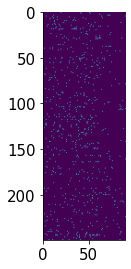

In [96]:
plt.imshow(ndat)

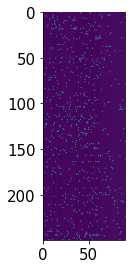

In [97]:
plt.imshow(ndat - ndat_mean)

250

In [118]:
s = np.tile(ndat_std,(ndat.shape[0],1))

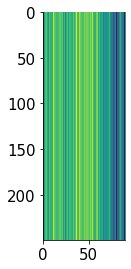

In [120]:
plt.imshow(s)

IndexError: index 145 is out of bounds for axis 0 with size 144

In [148]:
start_bin = 0 # in 10ms bin units
end_bin = 50 # in 10ms bin units
n_pcs= 5 # crossvalidation folds
k = 8
unit_idx_area = ILA

# NN = len(barea) # number of neurons
# NT = end_bin - start_bin # number of time bins
# NT = 1

# startbins = np.linspace(0,80,9).astype(int)
# endbins = np.linspace(10,90,9).astype(int)


#     droll = np.reshape(dat['spks'][barea,:,t:e], (NN,-1)) # concat trials per neuron
#     droll = droll - np.mean(droll, axis=1)[:, np.newaxis] # mean normalized

#     # PCA
#     model = PCA(n_components = n_pcs)
#     modelfit = model.fit(droll.T) # droll.T makes it shaped trials_timebins_concat x neurons
#     W = model.components_

#     pc_10ms = W @ np.reshape(dat['spks'][barea,:,start_bin:end_bin], (NN,-1)) # PCA_components @ unnormalized_data
#     pc_10ms = np.reshape(pc_10ms, (n_pcs, -1, NT))

#     # X_ = np.mean(pc_10ms, axis = 2).T
#     X_ = pc_10ms.transpose(2,0,1).reshape(-1,pc_10ms.shape[1]).T
accuracies_all = []

for n in unit_idx_area:
    ndat = np.squeeze(dat['spks'][n,:,:90]) # trials by time bins
    ndatz = np.nan_to_num(zscore(ndat)) # zscore across trials (within time bin)
#     break
    X = ndatz
    y = is_correct
    # define the model
    log_reg = LogisticRegression(penalty="none")
    # fit it to data
    log_reg.fit(X, y)
    # predict using all training data
    y_pred = log_reg.predict(X)
    train_accuracy = compute_accuracy(X, y, log_reg)
    accuracies_all.append(train_accuracy)
    # predict using cross_validation
#     accuracies = cross_val_score(LogisticRegression(penalty='none'), X, y, cv=k) # crossvalidation
#     accuracies_mean_all.append(accuracies.mean())
#     accuracies_sem = np.std(accuracies)/np.sqrt(len(accuracies))

#     print(f"Accuracy on the training data: {train_accuracy:.2%}")
#     print(f"Cross val mean Accuracy: {accuracies_mean:.2%}")
#     print(f"Cross val sem Accuracy: {accuracies_sem:.2%}")


/home/droumis/miniconda3/envs/capuchin/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/droumis/miniconda3/envs/capuchin/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/droumis/miniconda3/envs/capuchin/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/droumis/miniconda3/envs/capuchin/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/droumis/miniconda3/envs/capuchin/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd
/home/droumis/miniconda3/envs/capuchin/lib/python3.7/site-packages/scipy/stats/stats.py:2500: RuntimeWarning: inval

In [293]:
dat = alldat[7]
ILA = np.where([dat['brain_area'] == 'ILA'])[1]
PLA = np.where([dat['brain_area'] == 'PL'])[1]
CA1 = np.where([dat['brain_area'] == 'CA1'])[1]
VISp = np.where([dat['brain_area'] == 'VISp'])[1]

print(ILA.shape, PLA.shape, CA1.shape, VISp.shape)

response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
is_correct = np.sign(response)==np.sign(vis_left-vis_right)

(144,) (144,) (56,) (48,)


In [302]:
unit_idx_area = ILA
alldatz = np.nan_to_num(zscore(dat['spks'][:,:,:90]))
k = 8
d = np.arange(0,91,10)
startbins = d[:-1]
endbins = d[1:]

accuracies_all = []
for t,e in zip(startbins,endbins):
    #mean across current time bins
    ndat = np.mean(np.squeeze(alldatz[unit_idx_area,:,t:e]),-1).T # trials by neuron

    X = ndat
    y = is_correct
    # define the model
#     log_reg = LogisticRegression(penalty="l2")
#     # fit it to data
#     log_reg.fit(X, y)
#     # predict using all training data
#     y_pred = log_reg.predict(X)
#     train_accuracy = compute_accuracy(X, y, log_reg)
    accuracies = cross_val_score(LogisticRegression(penalty='l2'), X, y, cv=k) # crossvalidation
    accuracies_all.append(accuracies)
    

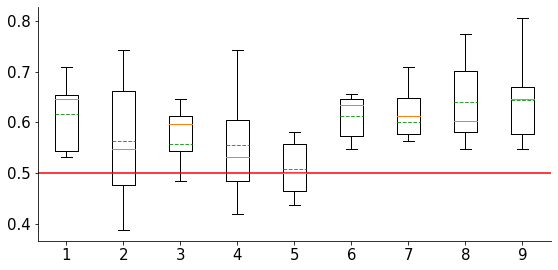

In [303]:
f, ax = plt.subplots(figsize=(8, 4))
ax.boxplot(accuracies_all, vert=True, widths=.4, meanline=True, showmeans=True, showcaps=True, 
                showbox=True, showfliers=False)
plt.axhline(.5, c='r')
# ax.scatter(accuracies, np.ones(k))
plt.show()

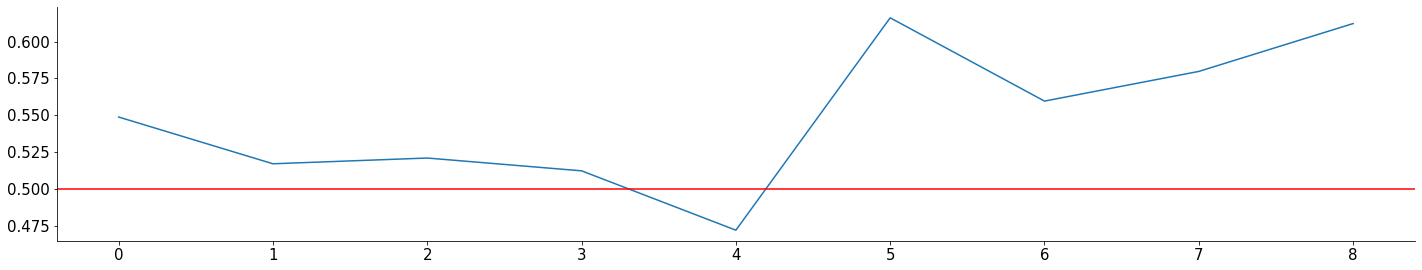

In [249]:
plt.plot(accuracies_all)
plt.axhline(.5, c='r')

In [152]:
len(accuracies_all)

144

In [58]:
ndat = np.squeeze(dat['spks'][barea[n],:,:90])

In [59]:
ndat.shape

(250, 90)

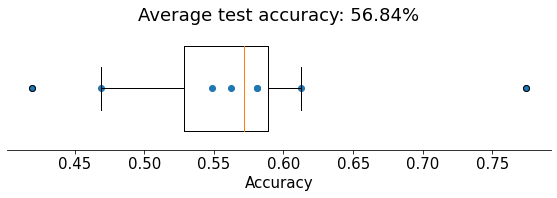

In [45]:
#@title
#@markdown Run to plot out these `k=8` accuracy scores.
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(k))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)
# plt.savefig('/home/droumis/Src/capuchin/figures/GLM_Accuracy_PCA_prestimANDstim_10PC.png')
plt.show()

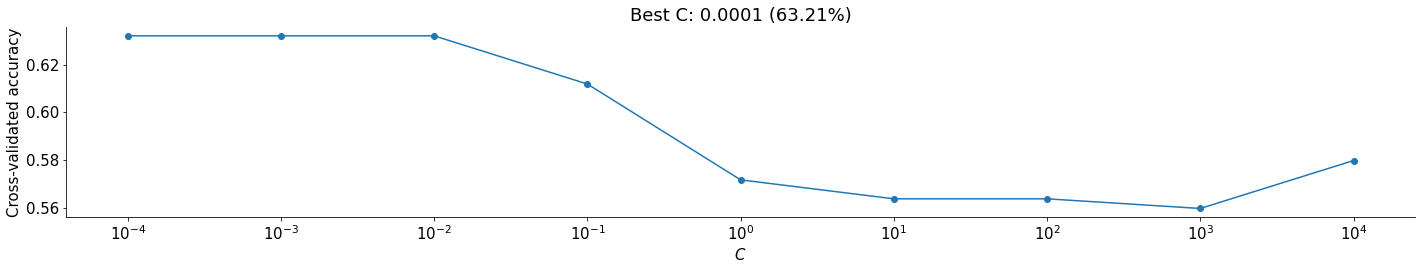

In [46]:
# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

accuracies = model_selection(X, y, C_values)
# with plt.xkcd():
plot_model_selection(C_values, accuracies)

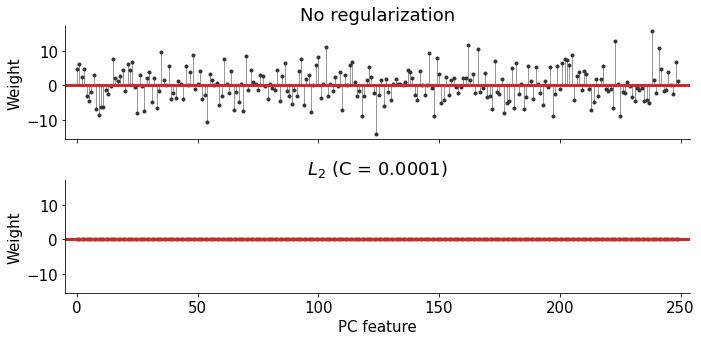

In [47]:
best_C = C_values[np.argmax(accuracies)]
log_reg_l2 = LogisticRegression(penalty="l2", C=best_C).fit(X, y)

# now show the two models
models = {
  "No regularization": log_reg,
  f"$L_2$ (C = {best_C})": log_reg_l2,
}
plot_weights(models, sharey=True)
# plot_weights(models["$L_2$ (C = @best_C)"].item())

In [12]:
start_duration = 0 # in 10ms bin units
end_duration = 90 # in 10ms bin units

NN = len(dat['brain_area']) # number of neurons
NT = dat['spks'][:,:,start_duration:end_duration].shape[-1]

response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
is_correct = np.sign(response)==np.sign(vis_left-vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10) 